## **Leaflet monthly print-run aggregator + basic statistics & visualization**
- Upload a ZIP archive containing .txt files (filenames only are parsed)
- User defines the value to substitute for unknown print runs ('unk')
- Aggregates print runs per month (YYYY-MM)
- Computes mean, median, ANOVA and Kruskal–Wallis tests
- Saves CSV output and plots bar charts, heatmaps, and cumulative plots

In [25]:
#@title 0) Import libraries
import zipfile
import io
import os
import re
import csv
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
import pandas as pd
from google.colab import files

In [26]:
#@title 1) Upload ZIP file
print("Upload a ZIP file containing .txt leaflet files.")
uploaded = files.upload()
if not uploaded:
    raise SystemExit("No file uploaded.")
zip_name = next(iter(uploaded.keys()))
zip_bytes = uploaded[zip_name]

Upload a ZIP file containing .txt leaflet files.


Saving latvian_communist_leaflets_1934-1939_all_leaflets_including_with_no_text.zip to latvian_communist_leaflets_1934-1939_all_leaflets_including_with_no_text.zip


In [27]:
#@title 2) Extract filenames from ZIP
z = zipfile.ZipFile(io.BytesIO(zip_bytes))
txt_members = [m for m in z.infolist() if m.filename.lower().endswith('.txt')]
if not txt_members:
    raise SystemExit("No .txt files found in ZIP.")
filenames = [os.path.basename(m.filename) for m in txt_members]

# --- NEW: read metadata from file contents (print_run, production_method, date -> YYYY-MM) ---

META_LINE_RE = re.compile(r'^(?P<key>[a-zA-Z0-9_]+)\s*:\s*(?P<val>.*)\s*$')

def parse_metadata_from_text(full_text: str) -> dict:
    meta = {}
    for line in full_text.splitlines():
        # stop at text field
        if line.strip().lower().startswith("text"):
            break
        m = META_LINE_RE.match(line.strip())
        if m:
            meta[m.group("key").strip()] = m.group("val").strip()
    return meta

def norm_print_run(v: str):
    if v is None:
        return "unk"
    v = v.strip().lower()
    if v in ("unk", "?", ""):
        return "unk"
    digits = re.sub(r"[^\d]", "", v)
    return int(digits) if digits else "unk"

def norm_prod_method(v: str):
    if v is None:
        return "unk"
    v = v.strip().lower()
    if v in ("", "unk", "?"):
        return "unk"
    return v  # expected: typographic / rotator / shapirograph

def extract_year_month_from_date_field(date_val: str):
    if not date_val:
        return None
    m = re.search(r"(19\d{2})-(\d{2})", date_val)
    return f"{m.group(1)}-{m.group(2)}" if m else None

# Build metadata dict keyed by BASENAME filename (matches `filenames`)
meta_by_fname = {}
for m in txt_members:
    fname = os.path.basename(m.filename)
    raw = z.read(m).decode("utf-8", errors="replace")
    meta = parse_metadata_from_text(raw)
    meta_by_fname[fname] = {
        "print_run": norm_print_run(meta.get("print_run")),
        "production_method": norm_prod_method(meta.get("production_method")),
        "date_raw": meta.get("date", ""),
        "year_month": extract_year_month_from_date_field(meta.get("date", "")),
    }


In [28]:
#@title 3) Impute 'unk' print_run as median per production_method
known_rows = []
for fname in filenames:
    pr = meta_by_fname.get(fname, {}).get("print_run", "unk")
    pm = meta_by_fname.get(fname, {}).get("production_method", "unk")
    if isinstance(pr, int):
        known_rows.append((pm, pr))

df_known = pd.DataFrame(known_rows, columns=["production_method", "print_run"])

# Medians by method (only from known numeric print runs)
med_by_pm = df_known.groupby("production_method")["print_run"].median().to_dict()

# Fallback: global median among all known numeric print runs
global_median = int(df_known["print_run"].median()) if not df_known.empty else 1000

print("Median print_run by production_method (known only):", {k: int(v) for k, v in med_by_pm.items()})
print("Global median fallback:", global_median)

def impute_print_run(fname: str) -> int:
    pr = meta_by_fname.get(fname, {}).get("print_run", "unk")
    pm = meta_by_fname.get(fname, {}).get("production_method", "unk")
    if isinstance(pr, int):
        return pr
    # unknown print run -> use median of its production_method (if available) else global median
    if pm in med_by_pm and not np.isnan(med_by_pm[pm]):
        return int(med_by_pm[pm])
    return global_median


Median print_run by production_method (known only): {'rotator': 2000, 'shapirograph': 300, 'typographic': 5000, 'unk': 2000}
Global median fallback: 3000


In [29]:
#@title 4) Helper functions for extracting year-month and print run (from file metadata)

def extract_print_run(fname):
    """Extract print_run from inside-file metadata. Returns int or 'unk'."""
    return meta_by_fname.get(fname, {}).get("print_run", None)

def extract_year_month(fname):
    """Extract YYYY-MM from inside-file metadata date field."""
    return meta_by_fname.get(fname, {}).get("year_month", None)


In [30]:
#@title 5) Aggregate print runs by month
monthly_totals = defaultdict(int)   # total print run per month
monthly_counts = defaultdict(int)   # number of leaflets per month
monthly_values = defaultdict(list)  # list of all print runs per month
unassigned = []

for fname in filenames:
    pr = extract_print_run(fname)
    ym = extract_year_month(fname)
    if ym is None:
        unassigned.append(fname)
        continue

    val = impute_print_run(fname)  # <<< NEW: median-by-production_method imputation
    monthly_totals[ym] += val
    monthly_counts[ym] += 1
    monthly_values[ym].append(val)

if unassigned:
    print("Files with NO parsed 19xx year-month in metadata (skipped):")
    for u in unassigned:
        print("  ", u)
    print()


Files with NO parsed 19xx year-month in metadata (skipped):
   revl_ex-n064x-LKP_I_district-200-1934.txt
   revl_ex-n065x-LKP_LKJS_Ventspils_district_committees-1500-1934.txt
   revl_ex-n114x-LKP_CK-10000-1935.txt
   revl_ex-n115x-LKP_Riga_committee-15000-1935.txt
   revl_ex-n116x-LKP_Riga_committee-15000-1935.txt
   revl_ex-n117x-LKP_Riga_committee-15000-1935.txt
   revl_ex-n118x-LKP_Riga_committee-15000-1935.txt
   revl_ex-n119x-LKP_Riga_committee-15000-1935.txt
   revl_ex-n120x-LKP_Riga_committee-15000-1935.txt
   revl_ex-n121x-LKP_Riga_committee-15000-1935.txt
   revl_ex-n122x-LKP_Riga_committee-15000-1935.txt
   revl_ex-n123x-LKP_Riga_org_students_faction-150-1935.txt
   revl_ex-n124x-LKP_Liepaja_org_transport_workers_district-unk-1935.txt
   revl_ex-n125x-LKP_Riga_org_West_district_committee-500-1935.txt
   revl_ex-n126x-LSSZP_CK-2500-1935.txt
   revl_ex-n127x-Latvian_Revolutionary_Writers_Artists_Journalists_Association_Central_Board-500-1935.txt
   revl_ex-n128x-Latvian_Revolut

In [31]:
#@title 6) Sort months chronologically
def ym_sort_key(ym):
    y, m = ym.split('-')
    return (int(y), int(m))
sorted_months = sorted(monthly_totals.keys(), key=ym_sort_key)

In [32]:
#@title 7) Compute mean & median per month
print("\n=== Monthly statistics ===")
summary = []
for ym in sorted_months:
    vals = monthly_values[ym]
    mean = np.mean(vals)
    median = np.median(vals)
    summary.append((ym, monthly_totals[ym], monthly_counts[ym], mean, median))
    print(f"{ym}: total={monthly_totals[ym]}, n={monthly_counts[ym]}, mean={mean:.1f}, median={median}")


=== Monthly statistics ===
1934-01: total=27700, n=11, mean=2518.2, median=2000.0
1934-02: total=39400, n=13, mean=3030.8, median=2000.0
1934-03: total=22500, n=8, mean=2812.5, median=2000.0
1934-04: total=46700, n=16, mean=2918.8, median=2000.0
1934-05: total=52000, n=21, mean=2476.2, median=2000.0
1934-06: total=8550, n=6, mean=1425.0, median=2000.0
1934-07: total=44400, n=20, mean=2220.0, median=2000.0
1934-08: total=27350, n=12, mean=2279.2, median=2000.0
1934-09: total=24750, n=12, mean=2062.5, median=1250.0
1934-10: total=30130, n=17, mean=1772.4, median=2000.0
1934-11: total=47000, n=13, mean=3615.4, median=3000.0
1934-12: total=23770, n=11, mean=2160.9, median=1500.0
1935-01: total=38850, n=18, mean=2158.3, median=2000.0
1935-02: total=51850, n=20, mean=2592.5, median=2000.0
1935-03: total=37900, n=16, mean=2368.8, median=2000.0
1935-04: total=73100, n=16, mean=4568.8, median=4000.0
1935-05: total=68100, n=20, mean=3405.0, median=3500.0
1935-06: total=7700, n=4, mean=1925.0, m

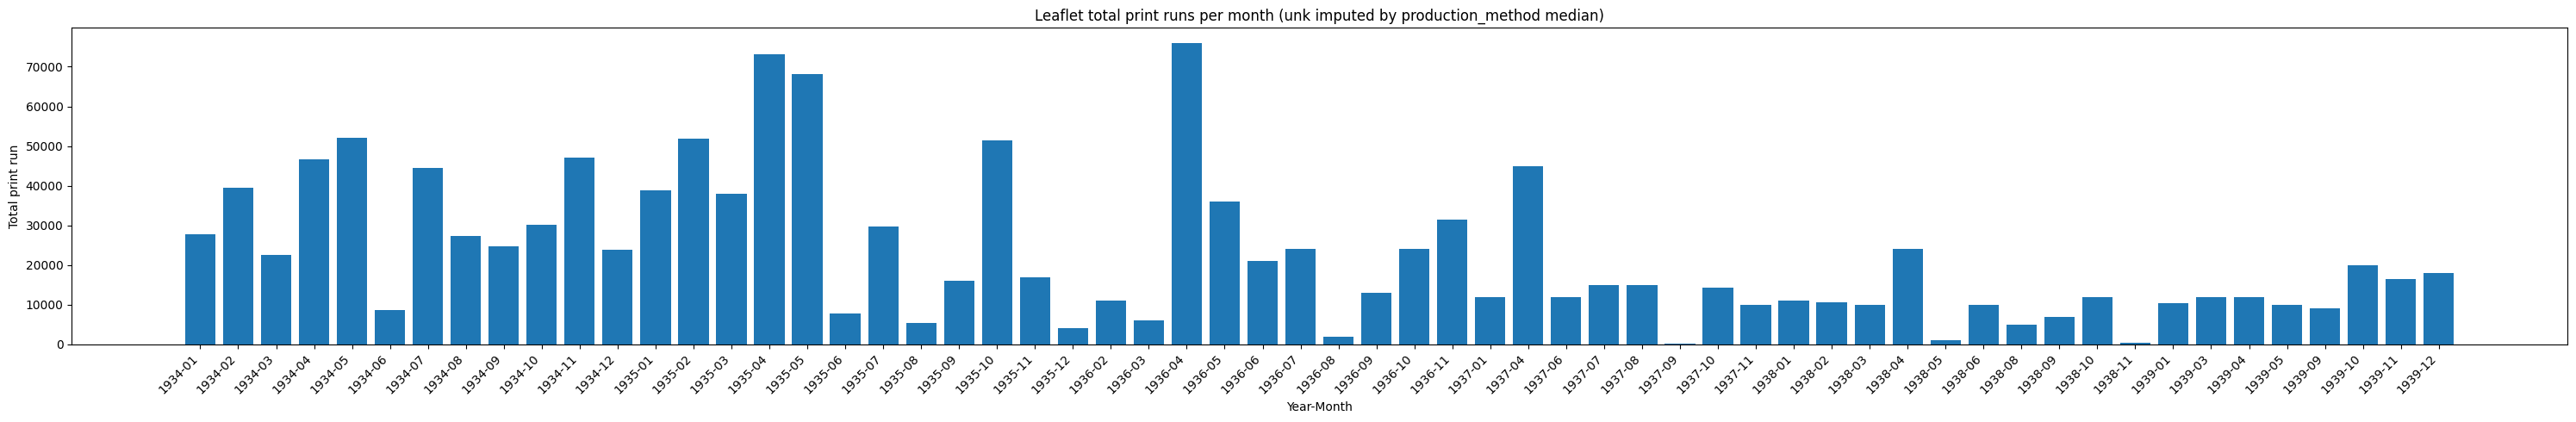

In [33]:
#@title 8) Bar chart of monthly total print runs
labels = sorted_months
values = [monthly_totals[ym] for ym in labels]

plt.figure(figsize=(max(8, len(labels)*0.5), 5))
plt.bar(range(len(values)), values)
plt.xticks(range(len(values)), labels, rotation=45, ha='right')
plt.xlabel('Year-Month')
plt.ylabel('Total print run')
plt.title('Leaflet total print runs per month (unk imputed by production_method median)')
plt.tight_layout()
plt.show()

Total unique normalized IDs: 244
Sum over years (should match): 244 

Leaflet counts per year:
1934: 94
1935: 72
1936: 29
1937: 15
1938: 13
1939: 21



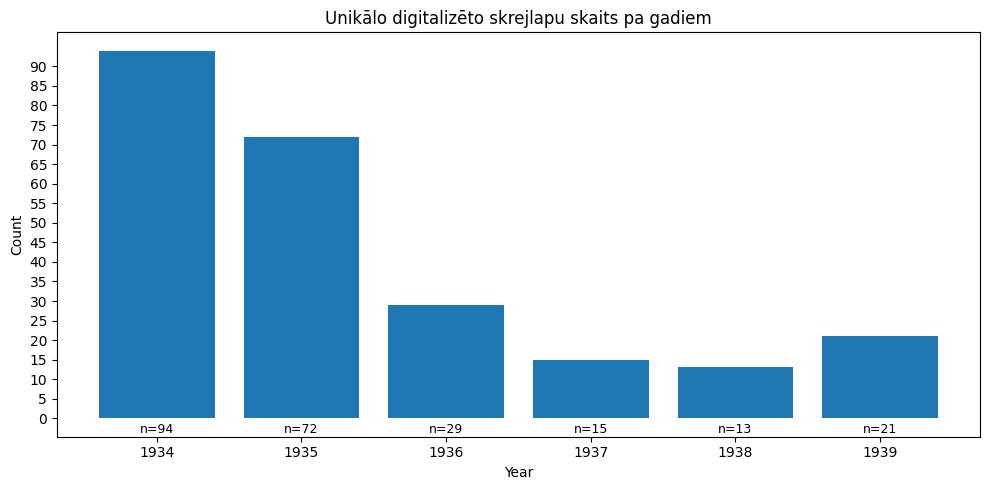

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

# Regex to extract leaflet ID (e.g., 'n197a', 'n251') from filenames like 'revl-n251-...' or 'revl-n001-...'
LEAFLET_ID_RE = re.compile(r'revl-(?P<id>n\d{1,3}[a-z]?)')

def extract_leaflet_id(fname):
    """Extracts leaflet ID from filename."""
    m = LEAFLET_ID_RE.search(fname)
    if m:
        return m.group('id')
    return None

DATE_RANGE_RE = re.compile(r'(?P<y1>19\d{2})-(?P<m1>\d{2})-(?P<d1>\d{2})\.\.(?P<y2>19\d{2})-(?P<m2>\d{2})-(?P<d2>\d{2})')
DATE_FULL_RE = re.compile(r'(?P<y>19\d{2})[-_](?P<m>\d{2})[-_](?P<d>\d{2})')
DATE_YM_RE = re.compile(r'(?P<y>19\d{2})[-_](?P<m>\d{2})')

def extract_full_date_string(fname):
    """Extracts the full date string (YYYY-MM-DD or YYYY-MM) from filename."""
    m_full = DATE_FULL_RE.search(fname)
    if m_full:
        return f"{m_full.group('y')}-{m_full.group('m')}-{m_full.group('d')}"
    m_ym = DATE_YM_RE.search(fname)
    if m_ym:
        return f"{m_ym.group('y')}-{m_ym.group('m')}"
    m_range = DATE_RANGE_RE.search(fname)
    if m_range:
        return f"{m_range.group('y1')}-{m_range.group('m1')}-{m_range.group('d1')}"
    return None

def normalize_id(id_value):
    """
    Returns '197a' and '197b' as '197' to count them as single document.
    All others return the same.
    """
    match = re.search(r'(\d+)', id_value)
    if match:
        return match.group(1)
    return id_value # Return original if no digits found

# Construct a DataFrame `df` from the `filenames` list
# (assuming `filenames` is available from cell 2)
leaflet_data = []
for fname in filenames:
    leaflet_id = extract_leaflet_id(fname)
    date_str = extract_full_date_string(fname)
    # Only add to data if both ID and date are successfully extracted
    if leaflet_id and date_str:
        leaflet_data.append({'id': leaflet_id, 'date': date_str})

df = pd.DataFrame(leaflet_data)

# If no data could be parsed, raise an error or inform the user
if df.empty:
    raise SystemExit("No leaflet data could be parsed from filenames to create DataFrame with 'id' and 'date' columns.")

df["id_normalized"] = df["id"].apply(normalize_id)

# Extract year as integer from date string
df["year"] = df["date"].str[:4].astype(int)

# For each normalized ID choose one canonical year (earliest year it appears)
id_year_min = (
    df.groupby("id_normalized")["year"]
      .min()
      .reset_index(name="year_canonical")
)

# Count unique leaflets per canonical year
leaflets_per_year = (
    id_year_min.groupby("year_canonical")["id_normalized"]
               .size()
               .sort_index()
)

# Sanity checks
print("Total unique normalized IDs:", df["id_normalized"].nunique())
print("Sum over years (should match):", leaflets_per_year.sum(), "\n")

# -------- PRINT leaflet count per year --------
print("Leaflet counts per year:")
for year, count in leaflets_per_year.items():
    print(f"{year}: {count}")
print()  # empty line

# -------- Plot histogram with labels under bars --------
plt.figure(figsize=(10, 5))
x = np.arange(len(leaflets_per_year))
heights = leaflets_per_year.values

plt.bar(x, heights)

# (excluding the same 198a 198b -> 198)
plt.title("Unikālo digitalizēto skrejlapu skaits pa gadiem")
plt.xlabel("Year")
plt.ylabel("Count")

plt.xticks(x, leaflets_per_year.index.astype(str))

max_y = heights.max()
plt.yticks(np.arange(0, max_y + 1, 5))

# Shift bottom to place n=... under bars
bottom = -max_y * 0.05
plt.ylim(bottom=bottom)

# Add n= labels under each bar
for i, cnt in enumerate(heights):
    plt.text(
        i,
        bottom + max_y * 0.001,  # small offset from the bottom
        f"n={cnt}",
        ha="center",
        va="bottom",
        fontsize=9
    )

plt.tight_layout()
plt.show()

In [35]:
#@title 9) Statistical tests: ANOVA / Kruskal–Wallis
print("\n=== Statistical test: Differences between months ===")
groups = [monthly_values[ym] for ym in sorted_months if len(monthly_values[ym]) > 1]
if len(groups) < 2:
    print("Not enough data for statistical test (need ≥2 months with ≥2 values each).")
else:
    f_val, p_val_anova = stats.f_oneway(*groups)
    h_val, p_val_kw = stats.kruskal(*groups)
    print(f"ANOVA: F = {f_val:.3f}, p = {p_val_anova:.5f}")
    print(f"Kruskal–Wallis: H = {h_val:.3f}, p = {p_val_kw:.5f}")
    if p_val_kw < 0.05:
        print("→ Statistically significant difference between months (p < 0.05)")
    else:
        print("→ No significant difference between months (p ≥ 0.05)")


=== Statistical test: Differences between months ===
ANOVA: F = 2.177, p = 0.00003
Kruskal–Wallis: H = 99.861, p = 0.00004
→ Statistically significant difference between months (p < 0.05)


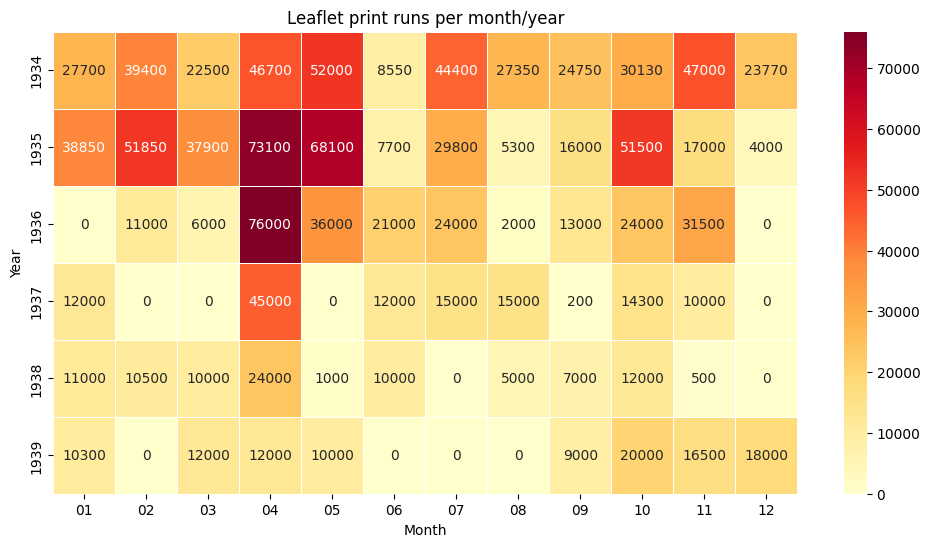

In [36]:
#@title 10) Heatmap of print runs by month and year
month_year_totals = defaultdict(int)
for ym, vals in monthly_values.items():
    y, m = ym.split('-')
    month_year_totals[(int(y), int(m))] = sum(vals)

years = sorted(set(y for y, m in month_year_totals.keys()))
months = list(range(1,13))

data = []
for y in years:
    row = [month_year_totals.get((y, m), 0) for m in months]
    data.append(row)

df = pd.DataFrame(data, index=years, columns=[f"{m:02d}" for m in months])

plt.figure(figsize=(12,6))
sns.heatmap(df, annot=True, fmt="g", cmap="YlOrRd", linewidths=0.5)
plt.title("Leaflet print runs per month/year")
plt.xlabel("Month")
plt.ylabel("Year")
plt.show()

Kopējais unikālo skrejlapu skaits: 244

Skrejlapu skaits pa mēnešiem un gadiem:
      01  02  03  04  05  06  07  08  09  10  11  12
1934   9   8   7  10   7   2  15   8   8   9   8   6
1935  11  15  10   9   7   2   9   2   3   5   3   1
1936   0   3   3   6   4   2   4   1   3   3   2   0
1937   1   0   0   3   0   4   4   1   1   4   2   0
1938   2   2   1   3   1   1   0   1   2   1   1   0
1939   2   0   3   2   3   0   0   0   3   2   6   1


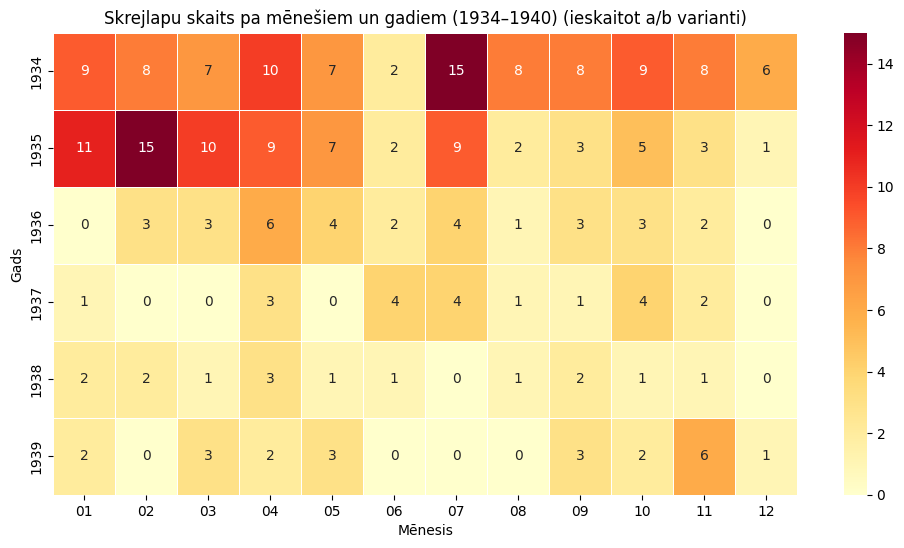

In [37]:
import pandas as pd
from collections import defaultdict
import re

# Assuming regexes from cell 3jL5R49SwOuj are available globally.
# Re-defining them here for clarity if this cell were run in isolation.
# DATE_RANGE_RE = re.compile(r'(?P<y1>19\d{2})-(?P<m1>\d{2})-(?P<d1>\d{2})\.\.(?P<y2>19\d{2})-(?P<m2>\d{2})-(?P<d2>\d{2})')
# DATE_FULL_RE = re.compile(r'(?P<y>19\d{2})[-_](?P<m>\d{2})[-_](?P<d>\d{2})')
# DATE_YM_RE = re.compile(r'(?P<y>19\d{2})[-_](?P<m>\d{2})')

# Regex to extract leaflet ID (e.g., 'n197a', 'n251') from filenames like 'revl-n251-...' or 'revl-n001-...'
LEAFLET_ID_RE = re.compile(r'revl-(?P<id>n\d{1,3}[a-z]?)')

def extract_leaflet_id(fname):
    """Extracts leaflet ID from filename."""
    m = LEAFLET_ID_RE.search(fname)
    if m:
        return m.group('id')
    return None

def extract_full_date_string(fname):
    """Extracts the full date string (YYYY-MM-DD or YYYY-MM) from filename.
       Uses existing DATE_FULL_RE, DATE_YM_RE, DATE_RANGE_RE from cell 3jL5R49SwOuj.
    """
    # Try to extract full date YYYY-MM-DD first
    m_full = DATE_FULL_RE.search(fname)
    if m_full:
        return f"{m_full.group('y')}-{m_full.group('m')}-{m_full.group('d')}"
    # Fallback to YYYY-MM if full date not found
    m_ym = DATE_YM_RE.search(fname)
    if m_ym:
        return f"{m_ym.group('y')}-{m_ym.group('m')}"
    # Fallback to start date of a range if available
    m_range = DATE_RANGE_RE.search(fname)
    if m_range:
        return f"{m_range.group('y1')}-{m_range.group('m1')}-{m_range.group('d1')}"
    return None


# Construct a DataFrame `df` from the `filenames` list
# (assuming `filenames` is available from cell 2)
leaflet_data = []
for fname in filenames:
    leaflet_id = extract_leaflet_id(fname)
    date_str = extract_full_date_string(fname)
    # Only add to data if both ID and date are successfully extracted
    if leaflet_id and date_str:
        leaflet_data.append({'id': leaflet_id, 'date': date_str})

df = pd.DataFrame(leaflet_data)

# If no data could be parsed, raise an error or inform the user
if df.empty:
    raise SystemExit("No leaflet data could be parsed from filenames to create DataFrame with 'id' and 'date' columns.")


def normalize_id(id_value):
    """
    Returns '197a' and '197b' as '197' to count them as single document.
    All others return the same.
    """
    # This regex matches digits in the ID (e.g., 'n197a' -> '197', 'n251' -> '251')
    match = re.search(r'(\d+)', id_value)
    if match:
        return match.group(1)
    return id_value # Return original if no digits found

df["id_normalized"] = df["id"].apply(normalize_id)

unique_leaflets = df["id_normalized"].nunique()

print("Kopējais unikālo skrejlapu skaits:", unique_leaflets)


# === 2) SASKAITĪT SKREJLAPAS PA MĒNEŠIEM ===

leaflet_counts = defaultdict(int)

for _, row in df.iterrows():
    date_str = row["date"]


    parts = date_str.split("-")
    year = int(parts[0])
    # Check if month part exists before trying to convert to int
    month = int(parts[1]) if len(parts) > 1 else None

    if month:
        leaflet_counts[(year, month)] += 1

years = sorted(set(y for y, m in leaflet_counts.keys()))
months = list(range(1, 13))

matrix = []
for y in years:
    row = [leaflet_counts.get((y, m), 0) for m in months]
    matrix.append(row)

df_monthly_leaflets = pd.DataFrame(
    matrix,
    index=years,
    columns=[f"{m:02d}" for m in months]
)

print("\nSkrejlapu skaits pa mēnešiem un gadiem:")
print(df_monthly_leaflets)

plt.figure(figsize=(12, 6))

sns.heatmap(
    df_monthly_leaflets,
    annot=True,
    fmt="g",
    cmap="YlOrRd",
    linewidths=0.5
)

plt.title("Skrejlapu skaits pa mēnešiem un gadiem (1934–1940) (ieskaitot a/b varianti)")
plt.xlabel("Mēnesis")
plt.ylabel("Gads")
plt.show()


Total normalized IDs (unique leaflets): 244
Rows in canonical DataFrame: 244

Skrejlapu skaits pa mēnešiem un gadiem (unikālie dokumenti, pēc normalizētiem ID):
      01  02  03  04  05  06  07  08  09  10  11  12
year                                                
1934   8   7   7  10   7   2  15   8   7   9   8   6
1935  10  14  10   8   7   2   9   2   3   4   2   1
1936   0   3   3   5   4   2   4   1   2   3   2   0
1937   0   0   0   3   0   3   2   1   1   3   2   0
1938   2   2   1   2   1   1   0   0   2   1   1   0
1939   2   0   3   2   2   0   0   0   3   2   6   1

Sum over all cells in table: 244


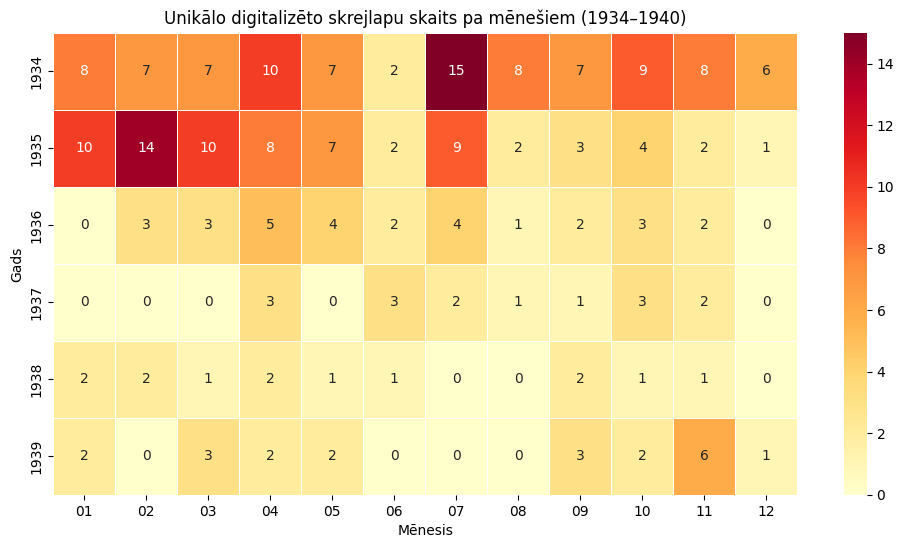

In [38]:
import pandas as pd
from collections import defaultdict
import re

# Regex to extract leaflet ID (e.g., 'n197a', 'n251') from filenames like 'revl-n251-...'
LEAFLET_ID_RE = re.compile(r'revl-(?P<id>n\d{1,3}[a-z]?)')

def extract_leaflet_id(fname: str) -> str | None:
    """Extracts leaflet ID from filename (e.g., 'n197a')."""
    m = LEAFLET_ID_RE.search(fname)
    if m:
        return m.group('id')
    return None

# Very tolerant regex: finds ANY '19xx-MM' in the filename,
# regardless of brackets, ranges, or ellipses.
DATE_YM_ANY_RE = re.compile(r'(19\d{2})[-_](\d{2})')

def extract_year_month(fname: str) -> str | None:
    """
    Extracts year-month (YYYY-MM) from filename.
    Works for patterns like:
      1936-03-18
      1936-03.txt
      [1935-02-01..1935-02-15]
      […1934-11-18]
      1935-01-07… etc.
    It simply finds the first '19xx-MM' substring.
    """
    m = DATE_YM_ANY_RE.search(fname)
    if m:
        year = m.group(1)
        month = m.group(2)
        return f"{year}-{month}"
    return None

def normalize_id(id_value: str) -> str:
    """
    Normalizes leaflet ID:
    'n197a' and 'n197b' -> '197' (counted as a single document).
    'n251' -> '251', etc.
    """
    match = re.search(r'(\d+)', id_value)
    if match:
        return match.group(1)
    return id_value  # fallback

# ---- Build DataFrame from filenames: one row per file ----
rows = []
for fname in filenames:
    leaflet_id = extract_leaflet_id(fname)
    ym = extract_year_month(fname)
    if leaflet_id and ym:
        rows.append({"id": leaflet_id, "year_month": ym})

df = pd.DataFrame(rows)

if df.empty:
    raise SystemExit("No leaflet data could be parsed from filenames (id + year_month).")

# Normalize IDs (merge letter variants)
df["id_normalized"] = df["id"].apply(normalize_id)

# Split year_month into numeric year and month
df["year"] = df["year_month"].str.slice(0, 4).astype(int)
df["month"] = df["year_month"].str.slice(5, 7).astype(int)

# For each normalized ID choose one canonical year-month: earliest (min year, then month)
# We create an integer key like YYYYMM to compare.
df["ym_int"] = df["year"] * 100 + df["month"]

canonical_idx = df.groupby("id_normalized")["ym_int"].idxmin()
df_canonical = df.loc[canonical_idx].copy()

print("Total normalized IDs (unique leaflets):", df["id_normalized"].nunique())
print("Rows in canonical DataFrame:", df_canonical.shape[0])

# === 2) COUNT LEAFLETS PER MONTH (using normalized IDs and canonical year-month) ===

df_monthly_leaflets = (
    df_canonical
      .groupby(["year", "month"])
      .size()
      .unstack(fill_value=0)   # columns = month numbers (1..12)
)

# Ensure all months 1..12 are present as columns
df_monthly_leaflets = df_monthly_leaflets.reindex(columns=range(1, 13), fill_value=0)

# Sort years and rename columns to "01".."12"
df_monthly_leaflets = df_monthly_leaflets.sort_index()
df_monthly_leaflets.columns = [f"{m:02d}" for m in df_monthly_leaflets.columns]

print("\nSkrejlapu skaits pa mēnešiem un gadiem (unikālie dokumenti, pēc normalizētiem ID):")
print(df_monthly_leaflets)

# Check that the sum over all cells equals the number of unique normalized IDs
print("\nSum over all cells in table:", int(df_monthly_leaflets.values.sum()))

plt.figure(figsize=(12, 6))
sns.heatmap(
    df_monthly_leaflets,
    annot=True,
    fmt="g",
    cmap="YlOrRd",
    linewidths=0.5
)

# (tikai unikālie dokumenti, burta sufiksa versijas nav skaitītas atsevišķi)
plt.title("Unikālo digitalizēto skrejlapu skaits pa mēnešiem (1934–1940)")
plt.xlabel("Mēnesis")
plt.ylabel("Gads")
plt.show()


1934-01: change from previous month = 0
1934-02: change from previous month = 11700
1934-03: change from previous month = -16900
1934-04: change from previous month = 24200
1934-05: change from previous month = 5300
1934-06: change from previous month = -43450
1934-07: change from previous month = 35850
1934-08: change from previous month = -17050
1934-09: change from previous month = -2600
1934-10: change from previous month = 5380
1934-11: change from previous month = 16870
1934-12: change from previous month = -23230
1935-01: change from previous month = 15080
1935-02: change from previous month = 13000
1935-03: change from previous month = -13950
1935-04: change from previous month = 35200
1935-05: change from previous month = -5000
1935-06: change from previous month = -60400
1935-07: change from previous month = 22100
1935-08: change from previous month = -24500
1935-09: change from previous month = 10700
1935-10: change from previous month = 35500
1935-11: change from previous m

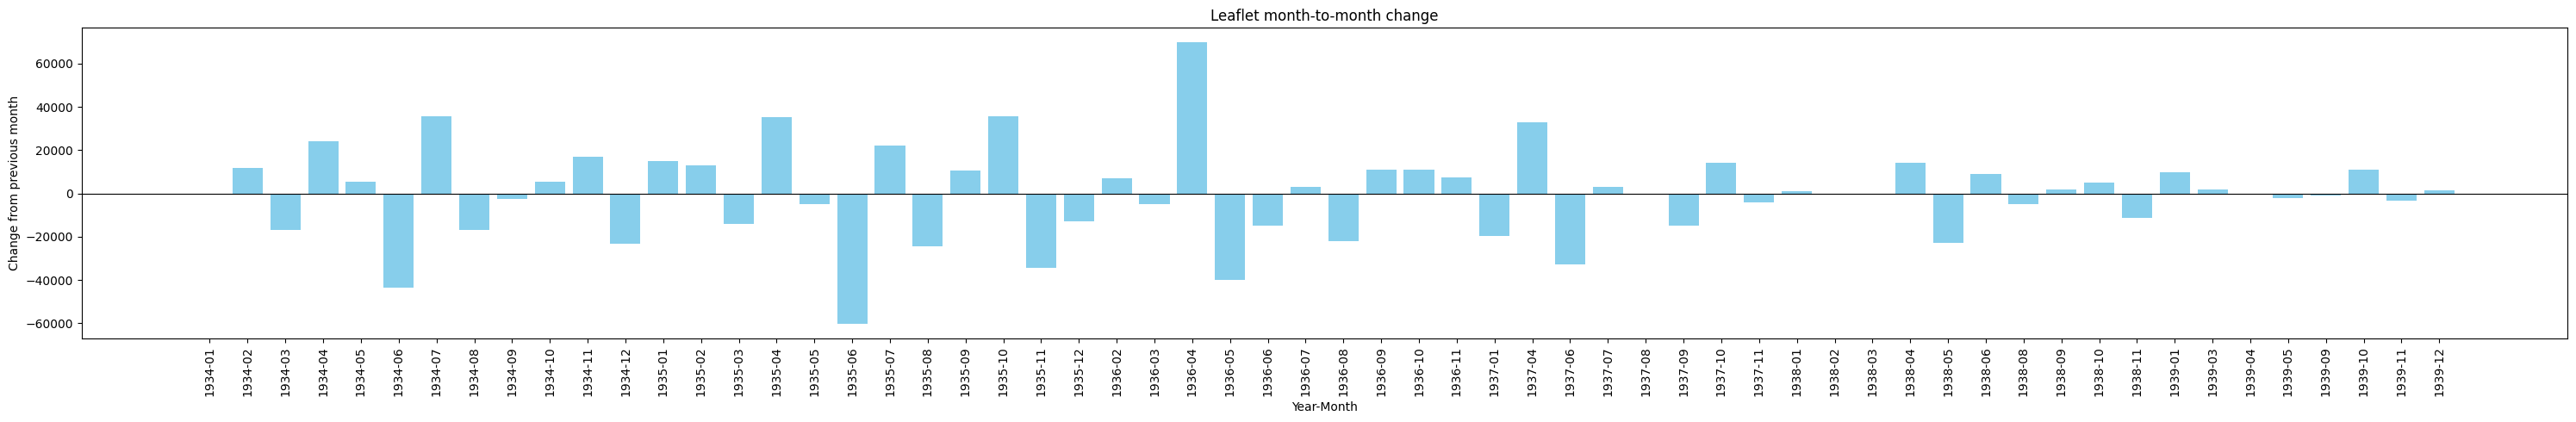

In [39]:
#@title 11) Month-to-month change
sorted_months = sorted(monthly_totals.keys(), key=ym_sort_key)
changes = []
labels = []

previous_total = None
for ym in sorted_months:
    total = monthly_totals[ym]
    if previous_total is None:
        change = 0
    else:
        change = total - previous_total
    previous_total = total
    changes.append(change)
    labels.append(ym)
    print(f"{ym}: change from previous month = {change}")

# ---- Plot ----
plt.figure(figsize=(max(10, len(labels)*0.5), 5))
plt.bar(range(len(changes)), changes, color='skyblue')
plt.xticks(range(len(labels)), labels, rotation=90)
plt.xlabel('Year-Month')
plt.ylabel('Change from previous month')
plt.title('Leaflet month-to-month change')
plt.axhline(0, color='black', linewidth=0.8)
plt.tight_layout()
plt.show()


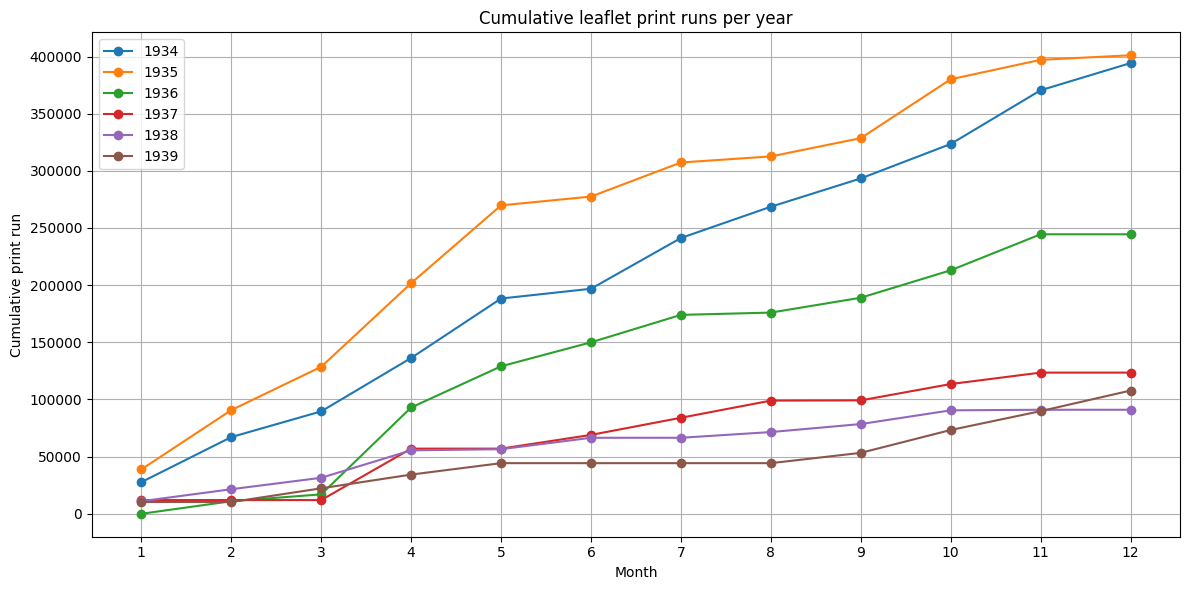

In [40]:
#@title 12) Cumulative print runs per year
year_month_totals = defaultdict(lambda: [0]*12)
for ym, vals in monthly_values.items():
    y, m = ym.split('-')
    year_month_totals[int(y)][int(m)-1] += sum(vals)

plt.figure(figsize=(12,6))
for y, month_totals in sorted(year_month_totals.items()):
    cumulative = np.cumsum(month_totals)
    plt.plot(range(1,13), cumulative, marker='o', label=str(y))

plt.xticks(range(1,13))
plt.xlabel('Month')
plt.ylabel('Cumulative print run')
plt.title('Cumulative leaflet print runs per year')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

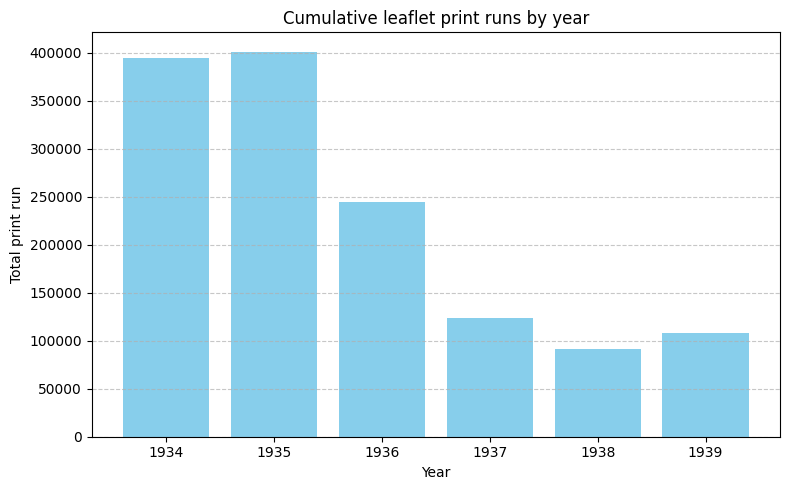

In [41]:
#@title 13) Annual cumulative print runs (simple histogram)
annual_totals = defaultdict(int)
for ym, vals in monthly_values.items():
    annual_totals[ym[:4]] += sum(vals)

years_sorted = sorted(annual_totals.keys())
totals_sorted = [annual_totals[y] for y in years_sorted]

plt.figure(figsize=(8,5))
plt.bar(years_sorted, totals_sorted, color='skyblue')
plt.xlabel('Year')
plt.ylabel('Total print run')
plt.title('Cumulative leaflet print runs by year')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

01: mean=19970, median=12000, vals=[27700, 38850, 12000, 11000, 10300]
02: mean=28188, median=25200, vals=[39400, 51850, 11000, 10500]
03: mean=17680, median=12000, vals=[22500, 37900, 6000, 10000, 12000]
04: mean=46133, median=45850, vals=[46700, 73100, 76000, 45000, 24000, 12000]
05: mean=33420, median=36000, vals=[52000, 68100, 36000, 1000, 10000]
06: mean=11850, median=10000, vals=[8550, 7700, 21000, 12000, 10000]
07: mean=28300, median=26900, vals=[44400, 29800, 24000, 15000]
08: mean=10930, median=5300, vals=[27350, 5300, 2000, 15000, 5000]
09: mean=11658, median=11000, vals=[24750, 16000, 13000, 200, 7000, 9000]
10: mean=25322, median=22000, vals=[30130, 51500, 24000, 14300, 12000, 20000]
11: mean=20417, median=16750, vals=[47000, 17000, 31500, 10000, 500, 16500]
12: mean=15257, median=18000, vals=[23770, 4000, 18000]


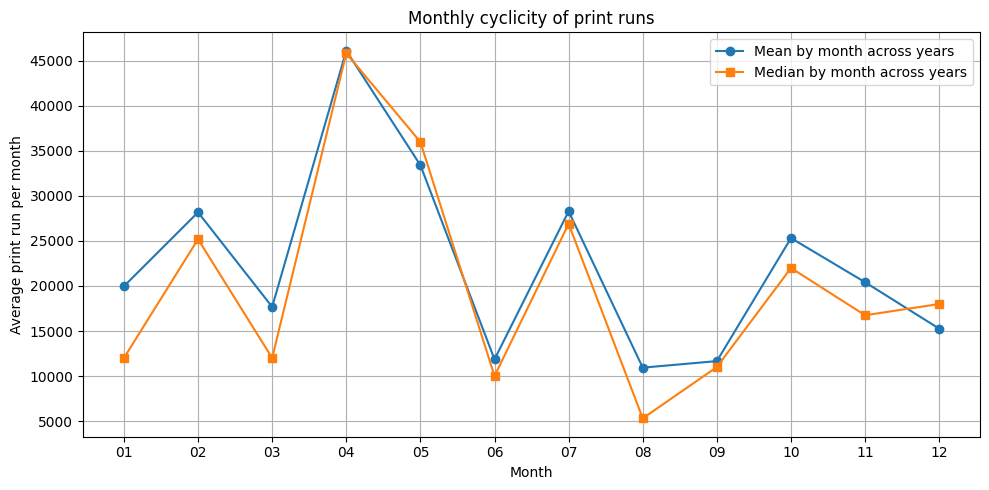

In [42]:
#@title 14) Aggregate total monthly print runs across all years
month_year_avg = defaultdict(list)

# Calculate the total print run for each month in each year
for ym, vals in monthly_values.items():
    y, m = ym.split('-')
    month_year_avg[m].append(sum(vals))

# --- Statistical Output ---

# Calculate and print mean/median for each month across all years
for m in sorted(month_year_avg.keys()):
    vals = month_year_avg[m]
    mean = int(round(np.mean(vals)))
    median = int(round(np.median(vals)))
    print(f"{m}: mean={mean}, median={median}, vals={vals}")

# --- Data Visualization ---

# Prepare data for plotting
months = sorted(month_year_avg.keys())
means = [np.mean(month_year_avg[m]) for m in months]
medians = [np.median(month_year_avg[m]) for m in months]

# Create and configure the plot
plt.figure(figsize=(10,5))
x = np.arange(len(months))
plt.plot(x, means, marker='o', label='Mean by month across years')
plt.plot(x, medians, marker='s', label='Median by month across years')
plt.xticks(x, months)
plt.xlabel('Month')
plt.ylabel('Average print run per month')
plt.title('Monthly cyclicity of print runs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

--- Statistics (Treating missing years as 0, Dividing by 6) ---
01: mean=16641, median=11500, zeros_added=1
02: mean=18791, median=10750, zeros_added=2
03: mean=14733, median=11000, zeros_added=1
04: mean=46133, median=45850, zeros_added=0
05: mean=27850, median=23000, zeros_added=1
06: mean=9875, median=9275, zeros_added=1
07: mean=18866, median=19500, zeros_added=2
08: mean=9108, median=5150, zeros_added=1
09: mean=11658, median=11000, zeros_added=0
10: mean=25321, median=22000, zeros_added=0
11: mean=20416, median=16750, zeros_added=0
12: mean=7628, median=2000, zeros_added=3


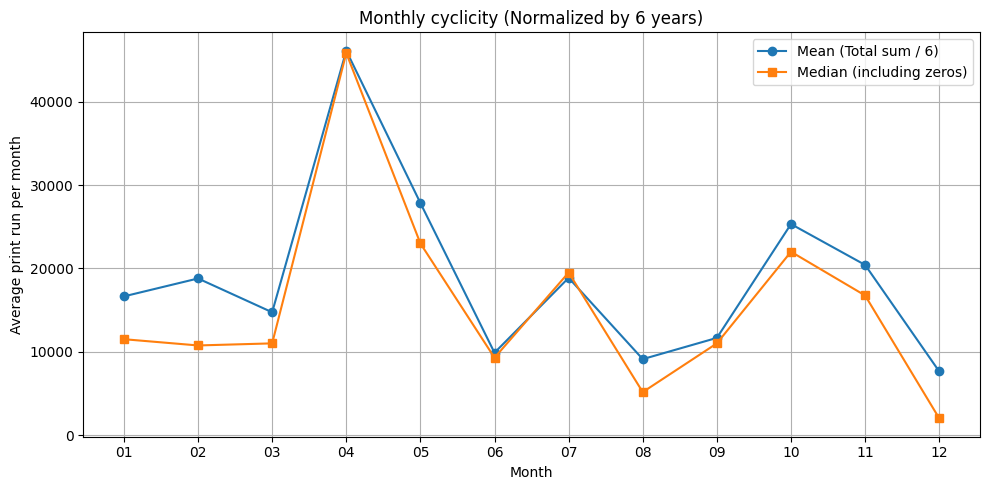

In [46]:
#@title 14) Aggregate with Zeros for Missing Years
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

TOTAL_YEARS = 6

month_year_avg = defaultdict(list)

for ym, vals in monthly_values.items():
    y, m = ym.split('-')
    month_year_avg[m].append(sum(vals))

# --- Statistical Output & Preparation ---
print(f"--- Statistics (Treating missing years as 0, Dividing by {TOTAL_YEARS}) ---")

all_months = [f"{i:02d}" for i in range(1, 13)]
means = []
medians = []

for m in all_months:
    vals = month_year_avg.get(m, [])

    missing_count = TOTAL_YEARS - len(vals)
    if missing_count > 0:
        vals.extend([0] * missing_count)

    mean_val = sum(vals) / TOTAL_YEARS
    median_val = np.median(vals)

    means.append(mean_val)
    medians.append(median_val)

    print(f"{m}: mean={int(mean_val)}, median={int(median_val)}, zeros_added={missing_count}")

# --- Data Visualization ---

plt.figure(figsize=(10, 5))
x = np.arange(len(all_months))

plt.plot(x, means, marker='o', label=f'Mean (Total sum / {TOTAL_YEARS})')
plt.plot(x, medians, marker='s', label='Median (including zeros)')

plt.xticks(x, all_months)
plt.xlabel('Month')
plt.ylabel('Average print run per month')
plt.title(f'Monthly cyclicity (Normalized by {TOTAL_YEARS} years)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


=== Tekstisks kopsavilkums pa kalendāra mēnešiem (gada kopējās tirāžas; trūkstošie gadi = 0) ===

Mēnesis 01: gadu skaits = 6, gadi = [1934–1939], 0 vērtību skaits = 1
  Kopējā tirāža visos gados = 99850, vidējā = 16642, mediāna = 11500
  Min = 0, Q1 = 10475, mediāna = 11500, Q3 = 23775, max = 38850
  IQR = 13300, apakšējā ūsas robeža = 0, augšējā ūsas robeža = 38850
  Std = 12819, izlecēju skaits = 0, izlecēji = []

Mēnesis 02: gadu skaits = 6, gadi = [1934–1939], 0 vērtību skaits = 2
  Kopējā tirāža visos gados = 112750, vidējā = 18792, mediāna = 10750
  Min = 0, Q1 = 2625, mediāna = 10750, Q3 = 32300, max = 51850
  IQR = 29675, apakšējā ūsas robeža = 0, augšējā ūsas robeža = 51850
  Std = 19804, izlecēju skaits = 0, izlecēji = []

Mēnesis 03: gadu skaits = 6, gadi = [1934–1939], 0 vērtību skaits = 1
  Kopējā tirāža visos gados = 88400, vidējā = 14733, mediāna = 11000
  Min = 0, Q1 = 7000, mediāna = 11000, Q3 = 19875, max = 37900
  IQR = 12875, apakšējā ūsas robeža = 0, augšējā ūsas

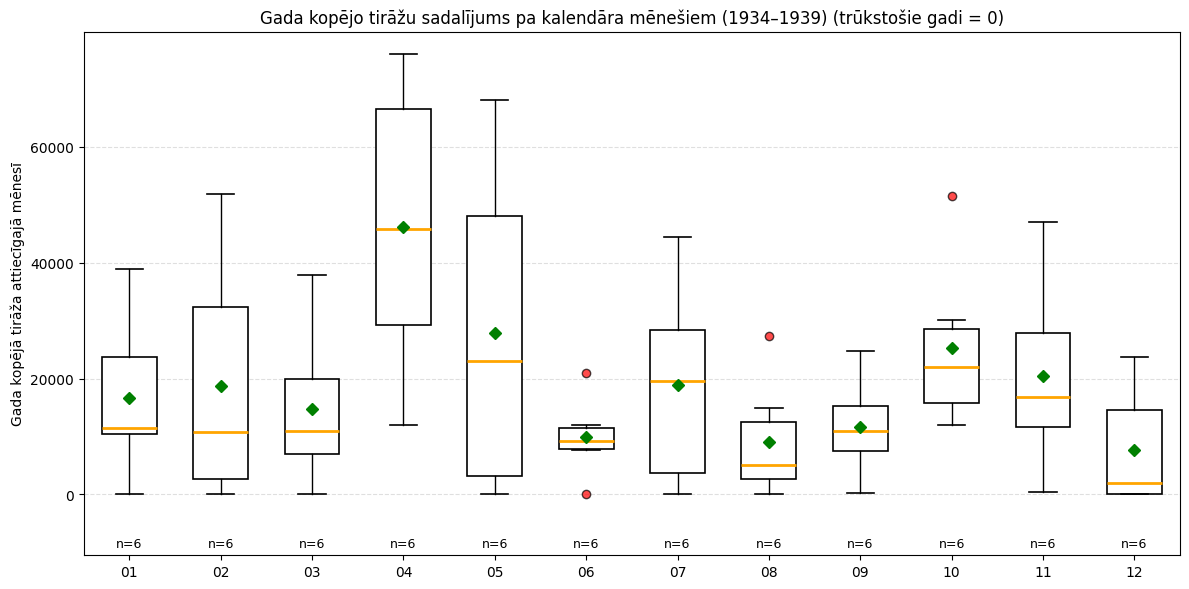

In [48]:
#@title 15) Boxplotu grafiki + mēnešu tekstiskais kopsavilkums (Tjūkija noteikumi) [zeros for missing years]

import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np

# Build month -> {year: sum} map
month_year_sums = defaultdict(lambda: defaultdict(int))
all_years = set()

for ym, vals in monthly_values.items():
    try:
        year = int(ym[:4])
        month = ym[5:7]  # "01".."12"
    except Exception:
        continue
    all_years.add(year)
    month_year_sums[month][year] += int(np.sum(vals))

# Determine full year range present in the corpus (e.g., 1934..1940)
if not all_years:
    raise SystemExit("No years found in monthly_values.")
years_full = list(range(min(all_years), max(all_years) + 1))

# Prepare month data with zeros for missing years
months = [f"{i:02d}" for i in range(1, 13)]
month_data = []
month_years = []  # parallel list of years lists for reference (always full years now)

for m in months:
    vals_by_year = month_year_sums.get(m, {})
    vals_full = [int(vals_by_year.get(y, 0)) for y in years_full]  # <<< zeros inserted here
    month_data.append(vals_full)
    month_years.append(years_full)

print("\n=== Tekstisks kopsavilkums pa kalendāra mēnešiem (gada kopējās tirāžas; trūkstošie gadi = 0) ===\n")

for m, vals, yrs in zip(months, month_data, month_years):
    arr = np.array(vals, dtype=float)
    n = len(arr)  # should equal len(years_full) for all months
    total_sum = int(arr.sum())
    mean = float(arr.mean())
    median = float(np.median(arr))
    q1 = float(np.percentile(arr, 25))
    q3 = float(np.percentile(arr, 75))
    iqr = q3 - q1

    # Tukey fences
    lower_fence = q1 - 1.5 * iqr
    upper_fence = q3 + 1.5 * iqr

    # whiskers: min/max within fences
    non_outliers = arr[(arr >= lower_fence) & (arr <= upper_fence)]
    if non_outliers.size > 0:
        lower_whisker = float(non_outliers.min())
        upper_whisker = float(non_outliers.max())
    else:
        lower_whisker = q1
        upper_whisker = q3

    # outliers (relative to whiskers)
    outlier_mask = (arr < lower_whisker) | (arr > upper_whisker)
    outliers = arr[outlier_mask].tolist()

    std = float(arr.std(ddof=0))
    mn = float(arr.min())
    mx = float(arr.max())

    yrs_str = f"{yrs[0]}–{yrs[-1]}" if yrs else ""
    zeros_count = int(np.sum(arr == 0))

    print(f"Mēnesis {m}: gadu skaits = {n}, gadi = [{yrs_str}], 0 vērtību skaits = {zeros_count}")
    print(f"  Kopējā tirāža visos gados = {total_sum}, vidējā = {int(round(mean))}, mediāna = {int(round(median))}")
    print(f"  Min = {int(mn)}, Q1 = {int(round(q1))}, mediāna = {int(round(median))}, Q3 = {int(round(q3))}, max = {int(mx)}")
    print(f"  IQR = {int(round(iqr))}, apakšējā ūsas robeža = {int(round(lower_whisker))}, augšējā ūsas robeža = {int(round(upper_whisker))}")
    print(f"  Std = {int(round(std))}, izlecēju skaits = {len(outliers)}, izlecēji = {[int(round(x)) for x in outliers]}")
    print("")

# ---- Boxplots ----
fig, ax = plt.subplots(figsize=(12, 6))

bp = ax.boxplot(
    month_data,                 # always 12 months, each has same number of years
    tick_labels=months,
    showmeans=True,
    patch_artist=True,
    widths=0.6,
    whis=1.5,
    flierprops=dict(marker='o', markerfacecolor='red', markersize=6, linestyle='none', alpha=0.7),
    medianprops=dict(color='orange', linewidth=2),
    meanprops=dict(marker='D', markeredgecolor='green', markerfacecolor='green', markersize=6)
)

for box in bp['boxes']:
    box.set(facecolor='white', edgecolor='black', linewidth=1.2)
for whisker in bp['whiskers']:
    whisker.set(color='black', linewidth=1)
for cap in bp['caps']:
    cap.set(color='black', linewidth=1.2)
for median_line in bp['medians']:
    median_line.set(color='orange', linewidth=2)

ax.set_ylabel("Gada kopējā tirāža attiecīgajā mēnesī")
ax.set_title("Gada kopējo tirāžu sadalījums pa kalendāra mēnešiem (1934–1939) (trūkstošie gadi = 0)")
ax.grid(True, which='major', axis='y', linestyle='--', alpha=0.4)

# annotate n under each month (same for all months)
n_years = len(years_full)
ymin, ymax = ax.get_ylim()
ax.set_ylim(bottom=ymin - (ymax - ymin) * 0.08)

for i in range(1, 13):
    ax.text(
        i,
        ax.get_ylim()[0] + (ymax - ymin) * 0.01,
        f"n={n_years}",
        ha='center',
        va='bottom',
        fontsize=9,
        color='black'
    )

plt.tight_layout()
plt.show()


In [45]:
#@title 16) Save CSV with detailed statistics
csv_path = "monthly_print_runs_with_stats.csv"
with open(csv_path, 'w', encoding='utf-8', newline='') as f:
    writer = csv.writer(f)

    # Column headers
    writer.writerow([
        'year_month',           # "YYYY-MM"
        'year',                 # Year as integer
        'month_number',         # Month number (1-12)
        'total_print_run',      # Total print run for that month
        'n_leaflets',           # Number of leaflets in that month
        'mean_print_run',       # Average print run
        'median_print_run',     # Median print run
        'min_print_run',        # Minimum print run
        'max_print_run',        # Maximum print run
        'std_print_run',        # Standard deviation
        'Q1',                   # First quartile (25th percentile)
        'Q3',                   # Third quartile (75th percentile)
        'IQR',                  # Interquartile range
        'n_outliers',           # Number of outliers (Tukey rule)
        'outliers',             # List of outlier values
        'change_from_prev_month',      # Absolute change from previous month
        'pct_change_from_prev_month',  # Percent change from previous month
        'cumulative_year',            # Cumulative total for that year
        'cumulative_total'            # Cumulative total across all months
    ])

    cumulative_total = 0                  # Running total for all months
    prev_total = None                     # Total of previous month for change calculation
    cumulative_year_dict = defaultdict(int)  # Dictionary for yearly cumulative totals

    for ym, vals, n_leaflets in zip(sorted_months, [monthly_values[ym] for ym in sorted_months], [monthly_counts[ym] for ym in sorted_months]):
        arr = np.array(vals, dtype=float)
        total_sum = int(arr.sum())
        mean = float(arr.mean()) if len(arr) > 0 else 0
        median = float(np.median(arr)) if len(arr) > 0 else 0
        mn = float(arr.min()) if len(arr) > 0 else 0
        mx = float(arr.max()) if len(arr) > 0 else 0
        std = float(arr.std(ddof=0)) if len(arr) > 0 else 0
        q1 = float(np.percentile(arr, 25)) if len(arr) > 0 else 0
        q3 = float(np.percentile(arr, 75)) if len(arr) > 0 else 0
        iqr = q3 - q1

        # Identify outliers using Tukey's method
        lower_fence = q1 - 1.5 * iqr
        upper_fence = q3 + 1.5 * iqr
        outlier_mask = (arr < lower_fence) | (arr > upper_fence)
        outliers = [int(round(x)) for x in arr[outlier_mask]]
        n_outliers = len(outliers)

        # Month-to-month change
        change = 0 if prev_total is None else total_sum - prev_total
        pct_change = 0 if prev_total is None or prev_total == 0 else (change / prev_total) * 100
        prev_total = total_sum

        # Yearly and overall cumulative totals
        year = int(ym[:4])
        month_number = int(ym[5:7])
        cumulative_year_dict[year] += total_sum
        cumulative_year = cumulative_year_dict[year]
        cumulative_total += total_sum

        # Write row to CSV
        writer.writerow([
            ym, year, month_number, total_sum, n_leaflets,
            round(mean,1), round(median,1), int(mn), int(mx),
            round(std,1), int(round(q1)), int(round(q3)), int(round(iqr)),
            n_outliers, str(outliers),
            int(change), round(pct_change,1),
            cumulative_year, cumulative_total
        ])

print(f"\nCSV saved to {csv_path}")
files.download(csv_path)


CSV saved to monthly_print_runs_with_stats.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>